In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency res

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AirStream/merged_pollution_weather_data.csv')

In [ ]:
data[:10].to_csv('/content/drive/MyDrive/AirStream/first_10_rows.csv', index=False)

In [ ]:
data = data.drop(['weather_icon', 'weather_description', 'weather_main', 'weather_id', 'snow_3h', 'snow_1h', 'rain_3h', 'rain_1h', 'sea_level', 'grnd_level', 'wind_gust', 'visibility', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'temp_min', 'temp_max'], axis=1)


In [ ]:
data.columns

Index(['dt', 'main.aqi', 'components.co', 'components.no', 'components.no2',
       'components.o3', 'components.so2', 'components.pm2_5',
       'components.pm10', 'components.nh3', 'temp', 'dew_point', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all'],
      dtype='object')

In [ ]:
# Convert 'dt' column to datetime format
data['dt'] = pd.to_datetime(data['dt'])
# Extract useful time-based features
data['hour'] = data['dt'].dt.hour
data['day_of_week'] = data['dt'].dt.dayofweek
data['month'] = data['dt'].dt.month
data['day_of_year'] = data['dt'].dt.dayofyear

In [ ]:
data.columns
# "co":208.62,
# "no":0.0,
# "no2":0.95,
# "o3":82.97,
# "so2":0.41,
# "pm2_5":0.65,
# "pm10":1.22,
# "nh3":0.02,
# "temp":285.68,"feels_like":285.13,"pressure":1014,"humidity":82,"dew_point":282.69,"clouds_all":0,"wind_speed":11.18,"wind_deg":293}
# hour, day_of_week, month, day_of_year

Index(['dt', 'main.aqi', 'components.co', 'components.no', 'components.no2',
       'components.o3', 'components.so2', 'components.pm2_5',
       'components.pm10', 'components.nh3', 'temp', 'dew_point', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'hour',
       'day_of_week', 'month', 'day_of_year'],
      dtype='object')

In [ ]:
# Define the AQI breakpoints for pollutants (including O3)
aqi_breakpoints = {
    "pm2_5": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.0, 301, 500)
    ],
    "pm10": [
        (0.0, 54.0, 0, 50),
        (55.0, 154.0, 51, 100),
        (155.0, 254.0, 101, 150),
        (255.0, 354.0, 151, 200),
        (355.0, 424.0, 201, 300),
        (425.0, 604.0, 301, 500)
    ],
    "no2": [
        (0.0, 53.0, 0, 50),
        (54.0, 100.0, 51, 100),
        (101.0, 360.0, 101, 150),
        (361.0, 649.0, 151, 200),
        (650.0, 1249.0, 201, 300),
        (1250.0, 2049.0, 301, 500)
    ],
    "so2": [
        (0.0, 35.0, 0, 50),
        (36.0, 75.0, 51, 100),
        (76.0, 185.0, 101, 150),
        (186.0, 304.0, 151, 200),
        (305.0, 604.0, 201, 300),
        (605.0, 1004.0, 301, 500)
    ],
    "co": [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 50.4, 301, 500)
    ],
    "o3": [
        (0.0, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
        (0.201, 0.604, 301, 500)
    ]
}

# Function to calculate AQI for a given pollutant concentration based on breakpoints
def calculate_aqi(concentration, breakpoints):
    if pd.isna(concentration):
        return None  # Skip if concentration is missing (NaN)
    for low_c, high_c, low_aqi, high_aqi in breakpoints:
        if low_c <= concentration <= high_c:
            return ((high_aqi - low_aqi) / (high_c - low_c)) * (concentration - low_c) + low_aqi
    return None

# Function to recalculate the AQI using all components
def recalculate_aqi(row):
    aqi_values = []

    # Recalculate AQI for each pollutant
    aqi_values.append(calculate_aqi(row['components.pm2_5'], aqi_breakpoints['pm2_5']))
    aqi_values.append(calculate_aqi(row['components.pm10'], aqi_breakpoints['pm10']))
    aqi_values.append(calculate_aqi(row['components.no2'], aqi_breakpoints['no2']))
    aqi_values.append(calculate_aqi(row['components.so2'], aqi_breakpoints['so2']))
    aqi_values.append(calculate_aqi(row['components.co'] / 1000, aqi_breakpoints['co']))  # Convert CO to ppm
    aqi_values.append(calculate_aqi(row['components.o3'], aqi_breakpoints['o3']))  # Ozone (O3)

    # Filter out None values from aqi_values
    aqi_values = [value for value in aqi_values if value is not None]

    if aqi_values:
        # Return the maximum AQI value if there are valid values
        return max(aqi_values)
    else:
        # If all AQI values are None, return None or a default value (e.g., 0)
        return None

# Apply the function to your dataset (replace 'your_dataframe' with your actual dataframe)
data['main.aqi'] = data.apply(recalculate_aqi, axis=1)



In [ ]:
# Drop rows with any NaN values
data = data.dropna()


In [ ]:

data[:10].to_csv('/content/drive/MyDrive/AirStream/first_10_rows.csv', index=False)


In [ ]:
data.shape

(33146, 22)

In [ ]:
# Get column names and data types
column_info = pd.DataFrame({'Column Name': data.columns, 'Data Type': data.dtypes})

print(column_info)

                       Column Name       Data Type
dt                              dt  datetime64[ns]
main.aqi                  main.aqi         float64
components.co        components.co         float64
components.no        components.no         float64
components.no2      components.no2         float64
components.o3        components.o3         float64
components.so2      components.so2         float64
components.pm2_5  components.pm2_5         float64
components.pm10    components.pm10         float64
components.nh3      components.nh3         float64
temp                          temp         float64
dew_point                dew_point         float64
feels_like              feels_like         float64
pressure                  pressure           int64
humidity                  humidity           int64
wind_speed              wind_speed         float64
wind_deg                  wind_deg           int64
clouds_all              clouds_all           int64
hour                          h

In [ ]:
def remove_outliers(df, columns):
    # Apply IQR method to specified columns
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Specify the columns where we want to remove outliers
columns_to_check = ['main.aqi', 'components.co', 'components.no', 'components.no2',
                    'components.o3', 'components.so2', 'components.pm2_5', 'components.pm10',
                    'components.nh3', 'temp', 'dew_point', 'feels_like',
                    'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all',]

# Remove outliers from these columns
data_cleaned = remove_outliers(data, columns_to_check)

In [ ]:
data_cleaned.shape

(14273, 22)

In [ ]:
data_smoothed = data_cleaned.copy()
for column in columns_to_check:
    data_smoothed[column] = data_smoothed[column].rolling(window=3, center=True).mean()

# Drop any NaN values resulting from rolling mean
data_smoothed = data_smoothed.dropna().reset_index(drop=True)


In [ ]:
target_column = 'main.aqi'
data_values = data_smoothed.drop(columns=['dt', target_column])  # Input features without 'main.aqi'
aqi_target = data_smoothed[[target_column]].values  # main.aqi as the target

In [ ]:
# Standardize input features
scaler = StandardScaler()
data_values = scaler.fit_transform(data_values)  # Standardize all input features

In [ ]:
# Export scaler fitted on training set for reuse in kafka consumer:
scaler_path = '/content/drive/MyDrive/AirStream/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to Google Drive at {scaler_path}")

Scaler saved to Google Drive at /content/drive/MyDrive/AirStream/scaler.pkl


In [ ]:
from google.colab import files

files.download(scaler_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_values.head()

,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,temp,dew_point,feels_like,pressure,humidity,wind_speed,wind_deg,clouds_all,hour,day_of_week,month,day_of_year
0,236.990000,0.036667,10.940000,69.860000,1.416667,2.543333,5.030000,0.690000,285.990000,281.590000,285.276667,1018.666667,74.666667,2.623333,274.333333,13.333333,2,4,12,346
1,239.216667,0.000000,11.140000,68.666667,1.326667,2.623333,5.156667,0.713333,285.043333,281.143333,284.296667,1019.333333,77.000000,1.190000,265.333333,10.000000,3,4,12,346
2,238.103333,0.000000,10.683333,66.043333,1.296667,2.796667,5.516667,0.686667,284.510000,281.166667,283.790000,1020.000000,80.000000,1.190000,263.666667,10.000000,4,4,12,346
3,233.650000,0.000000,9.713333,64.373333,1.296667,2.920000,5.893333,0.613333,284.043333,281.420000,283.383333,1020.666667,84.000000,1.190000,265.000000,13.333333,5,4,12,346
4,226.973333,0.000000,8.313333,64.850000,1.283333,2.853333,5.923333,0.500000,283.486667,281.530000,282.870000,1021.000000,87.666667,1.490000,267.666667,23.333333,6,4,12,346


In [ ]:
# Define sequence and forecast lengths
sequence_length = 72  # 72 hours as input
forecast_horizon = 72  # Predict the next 72 hours

# Prepare sequences and targets
X, y = [], []
for i in range(len(data_values) - sequence_length - forecast_horizon + 1):
    # Input sequence: 72 hours of standardized features
    X.append(data_values[i:i + sequence_length])

    # Target sequence: Next 72 hours of main.aqi
    y.append(aqi_target[i + sequence_length:i + sequence_length + forecast_horizon].flatten())

# Convert to numpy arrays for the LSTM model
X = np.array(X)
y = np.array(y)

# Step 1: Split data into train (80%) and temporary (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the temporary set equally into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display shapes to confirm
print("Training set X:", X_train.shape, "y:", y_train.shape)
print("Validation set X:", X_val.shape, "y:", y_val.shape)
print("Test set X:", X_test.shape, "y:", y_test.shape)



Training set X: (11302, 72, 20) y: (11302, 72)
Validation set X: (1413, 72, 20) y: (1413, 72)
Test set X: (1413, 72, 20) y: (1413, 72)


In [ ]:
import numpy as np
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test,
                             lstm_units=[128,128], dropout_rate=0.3, learning_rate=0.001,
                             batch_size=32, epochs=50):
    """
    Train and evaluate an LSTM model with specified configurations.

    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - X_test, y_test: Test data
    - lstm_units: List of LSTM units for each layer (e.g., [128, 64] for two layers)
    - dropout_rate: Dropout rate (e.g., 0.3)
    - learning_rate: Learning rate for the optimizer (e.g., 0.001)
    - batch_size: Batch size (e.g., 32)
    - epochs: Number of epochs (e.g., 50)

    Returns:
    - Dictionary with model metrics (MSE, RMSE, MAE, R²)
    - Training history
    """

    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define the LSTM model
    model = Sequential()

    # Add LSTM layers based on lstm_units list
    for i, units in enumerate(lstm_units):
        if i == 0:
            # First LSTM layer needs input shape
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(lstm_units) - 1),
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(lstm_units) - 1)))
        model.add(Dropout(dropout_rate))  # Add dropout after each LSTM layer

    # Add the output layer
    model.add(Dense(y_train.shape[1]))  # Output layer matches the forecast horizon (e.g., 72)

    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Set up early stopping to monitor validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"Model Evaluation Metrics (Learning Rate: {learning_rate}, Dropout: {dropout_rate}, Layers: {lstm_units}):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-Squared (R²): {r2}")

    # Visualize training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Visualize predictions vs actuals
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_flat, label="Actual Values", color="blue")
    plt.plot(y_pred_flat, label="Predicted Values", color="orange", alpha=0.7)
    plt.title("Actual vs Predicted AQI Values on Test Set")
    plt.xlabel("Time Steps")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()

    # Return model performance metrics and training history
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }, history, model


In [ ]:
import numpy as np
import random
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate_complex_model(X_train, y_train, X_val, y_val, X_test, y_test,
                                     lstm_units=[128, 128], dropout_rate=0.3, learning_rate=0.0001,
                                     batch_size=32, epochs=50):
    """
    Train and evaluate a complex Bidirectional LSTM model.

    Returns:
    - Dictionary with model metrics (MSE, RMSE, MAE, R²)
    - Training history
    - Trained model
    """

    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define the model
    model = Sequential()

    # First layer: Bidirectional LSTM
    model.add(Bidirectional(LSTM(lstm_units[0], return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for units in lstm_units[1:]:
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # Flatten the output for final dense layer
    model.add(tf.keras.layers.Flatten())

    # Output layer
    model.add(Dense(y_train.shape[1]))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Learning rate scheduler and early stopping
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"Model Evaluation Metrics (Learning Rate: {learning_rate}, Dropout: {dropout_rate}, Layers: {lstm_units}):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-Squared (R²): {r2}")

    # Visualize training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Visualize predictions vs actuals
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_flat, label="Actual Values", color="blue")
    plt.plot(y_pred_flat, label="Predicted Values", color="orange", alpha=0.7)
    plt.title("Actual vs Predicted AQI Values on Test Set")
    plt.xlabel("Time Steps")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()

    # Return model performance metrics, training history, and trained model
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }, history, model


Testing with dropout rate: 0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 249.3515 - val_loss: 230.0471
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 226.6045 - val_loss: 224.9731
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 224.4096 - val_loss: 219.6225
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 218.7319 - val_loss: 213.6313
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 212.4090 - val_loss: 206.9928
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 204.0274 - val_loss: 149.7277
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 143.8409 - val_loss: 119.5562
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 113.2915 - val_loss: 85.2993
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 77.2809 - val_loss: 47.1299
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 52.3655 - val_loss: 41.3202
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 46.2599 - val_loss: 38.8046
Epo

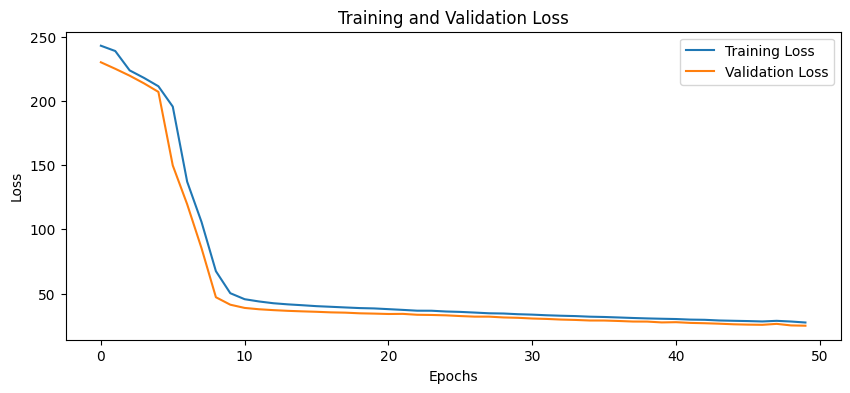

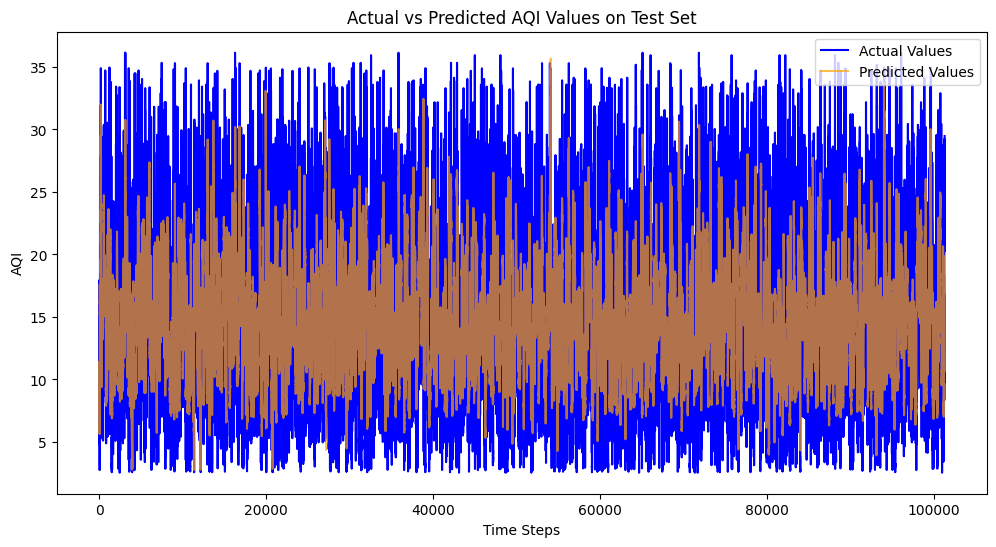

Dropout Rate: 0.3
Metrics: {'MSE': 25.49027313387358, 'RMSE': 5.048789274061018, 'MAE': 3.956968056312311, 'R²': 0.41372700103547694}


In [ ]:

rate = 0.3

# Iterate over each dropout rate and evaluate the model

print(f"Testing with dropout rate: {rate}")

metrics, history, model = train_and_evaluate_model(
        X_train, y_train, X_val, y_val, X_test, y_test,
        lstm_units=[128, 128],
        dropout_rate=0.3,
        learning_rate=0.0001,
        batch_size=32,
        epochs=50
    )

print("Dropout Rate:", rate)
print("Metrics:", metrics)
print("=" * 50)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 115.7065 - val_loss: 34.2619 - learning_rate: 1.0000e-04
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 32.9361 - val_loss: 27.1480 - learning_rate: 1.0000e-04
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 25.8282 - val_loss: 21.5738 - learning_rate: 1.0000e-04
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 20.3306 - val_loss: 16.8489 - learning_rate: 1.0000e-04
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 16.3188 - val_loss: 14.0653 - learning_rate: 1.0000e-04
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 13.8815 - val_loss: 12.2731 - learning_rate: 1.0000e-04
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 12.2191 - val_loss: 10.8054 - learning_rate: 1.0000e-04
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 11.0155 - val_loss: 9.7180 - learning_rate: 1.0000e-04
Epoch 9/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 10.

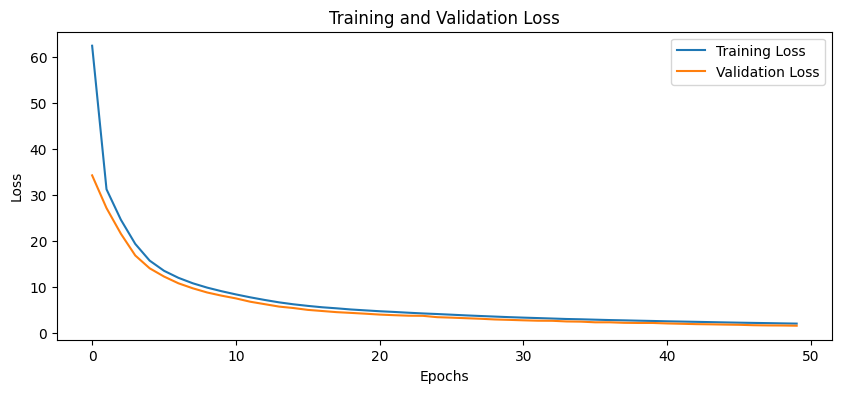

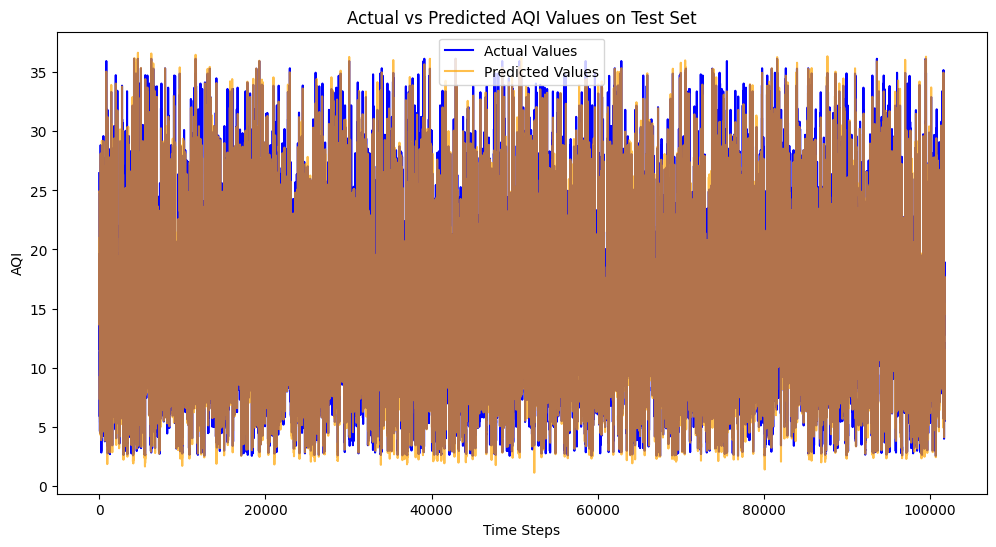

Final Model Evaluation Metrics:
MSE: 1.6154748677416726
RMSE: 1.2710133231959737
MAE: 0.9175926960695462
R²: 0.9642590403847472


In [ ]:
lstm_units = [128, 128]  # Two LSTM layers with 128 units each
dropout_rate = 0.3       # Dropout rate
learning_rate = 0.0001   # Learning rate
batch_size = 32          # Batch size
epochs = 50              # Number of epochs

# Call the model training and evaluation function
metrics, history, model = train_and_evaluate_complex_model(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    lstm_units=lstm_units,
    dropout_rate=dropout_rate,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs
)

# Displaying metrics
print("Final Model Evaluation Metrics:")
print(f"MSE: {metrics['MSE']}")
print(f"RMSE: {metrics['RMSE']}")
print(f"MAE: {metrics['MAE']}")
print(f"R²: {metrics['R²']}")

In [ ]:

model.save("trained_aqi_model.keras")
print("Model saved as 'trained_aqi_model.keras'")


Model saved as 'trained_aqi_model.keras'


In [ ]:
from google.colab import files

# Download the model to your local computer
files.download("/content/drive/MyDrive/AirStream/trained_aqi_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define the path in Google Drive where you want to save the model
model_save_path = "/content/drive/MyDrive/AirStream/trained_aqi_model.keras"

# Save the model to Google Drive
model.save(model_save_path)
print(f"Model saved to Google Drive at {model_save_path}")


Model saved to Google Drive at /content/drive/MyDrive/AirStream/trained_aqi_model.keras
